<a href="https://colab.research.google.com/github/cochedayan/TrueStrategy/blob/main/loc_list_copie_FTX_EMA311_15M_4H.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Programme adapte au dates FTX. A utiliser apres tests d'une crypto sur une longue periode avec BNC

Relever le cours toutes les 4 heures et calculer les EMA. Acheter quand EMA3>EMA11 au prix du cours. Vendre quand EMA11>EMA3 au prix de la cloture15M car il y a au moins 10 bougies au dessus de ce prix apres placement de l'ordre de vente . Il faut donc relever le cours toutes les 15 minutes. Parametrer le jour de reference (decale_jours) a minima 44 heures pour construire le tableaux de fusion. Demarrer quand EMA11 > EMA3 sur 8H et dans un creux qui remonte.

<h1>Installation des packages</h1>

Bibliothèque Python3 non officielle pour interagir avec l'API [FTX]

In [1]:
pip install ftx

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for ciso8601: filename=ciso8601-2.2.0-cp37-cp37m-linux_x86_64.whl size=37520 sha256=a6dad496d931d8ef71bd855b01a679de8072814e4948eeeacdf26e648b20d6c0
  Stored in directory: /root/.cache/pip/wheels/ad/25/8f/3b0a82303191efe3c1204f3741c42d8eb2b0236567e22485de
Successfully built ciso8601


Bibliothèque pandas pour l'analyse techniques des données financières

In [2]:
pip install ta

  Created wheel for ta: filename=ta-0.10.1-py3-none-any.whl size=28985 sha256=e265439fa6cdd1674580f9fef632e2b3e38d0e54d007871cce87ea695a3f0621
  Stored in directory: /root/.cache/pip/wheels/bc/2a/c2/a56e77d07edc16a1fa7fb012667e55cb0643cfa65996bddecc
Successfully built ta


<h1>Charger les packages</h1>


In [3]:
import ftx
import pandas as pd
from pandas.errors import UnsupportedFunctionCall
#import json
import ta
import time as ti #renome sinon pb avec le time de datetime
from datetime import datetime, date, time, timedelta
import pytz
from math import *
import numpy as np

import matplotlib.pyplot as plt

<h1>Parametrer (paire, variables ...)</h1>

In [4]:
################## Parametres pour le test
usdt = 100
coin = 0
fee = 0.000665
achat = 0

################## Parametres crypto
pairSymbol = 'TRX/USD'
cryptoSymbol = 'TRX'
fiatSymbol = 'USD'
tronque_usdt = 7
tronque_coin = 0
Minimum_order_size = 1
Minimum_price_increment = 0.0000025

# Valeurs des variables pour ces cryptos
#symbol = 'XX '                      #SOL/USD   #LINK/USD   #ETH/USD  #XRP/USD   #ATOM/USD  #DENT/USD   #TRX  
#tronque_usd = 4                     #4         #4          #1        #          #4         #6          #7
#tronque_coin = 1                    #2         #1          #3        #          #1         #0          #0
#Minimum_order_size = 0.1            #0.01      #0.1        #0.001    #1         #0.1       #100        #1
#Minimum_price_increment = 0.0000025    #0.0025    #0.0005     #0.1      #0.000025  #0.0025    #0.000001   #0.0000025

################## Initialisation
prix_achat = 999999
mise = 0
prix_vente = 0

############# Fonctions
def truncate(n, decimals=0):
    r = floor(float(n)*10**decimals)/10**decimals
    return float(r)

################## Connection
from ftx import FtxClient
client = FtxClient()

############ Reglage du decalage jour
#valeurs possibles de decale_jours : [2,..,31]
decale_jours = 26
#valeurs possibles de decale_heure : [00,4,8,12,16,20]
decale_heure = 0
#date du jour en UTC a minuit
tz = pytz.timezone('UTC')
date_jour = date.today()
date_jour_minuit_strp = datetime.combine(date_jour, time())
print('date_jour_minuit_strp :',date_jour_minuit_strp)
#jour decale en UTC a minuit
date_decale_ts = datetime.timestamp(date_jour_minuit_strp + timedelta(days = -decale_jours, hours = +decale_heure))
print('date_decale_ts:', str(date_decale_ts))
date_decale_julien = datetime.fromtimestamp(date_decale_ts)
print('date_decale_julien:',date_decale_julien)


date_jour_minuit_strp : 2022-05-11 00:00:00
date_decale_ts: 1649980800.0
date_decale_julien: 2022-04-15 00:00:00


<h1>Recuperer les donnees. Creer un tableau 15 M et un 4H avec les indicateurs EMA3/11</h1>

In [5]:
################## Relever les donnees pour le dataframe de 15M
# resolution = largeur de la bougie en secondes. Donc pour un timelaps de 15 min, resolution = 900 (15 X 60sec) 
# resolution proposee : 15, 60, 300, 900, 3600, 14400, 86400 puis multiples de 86400
# limit = historique des donnees. Maxi autorise = 3450. 
# Au minimum limit = 176 (16 x 11). 16 car il y a 16 1/4h dans 4h et 11 car il faut 11 periodes de 4h pour faire EMA11
# demmarer a l-heure actuelle moins les 16 dernieres periodes et finir a l-heure actuelle
# class datetime.datetime(year, month, day, hour=0, minute=0, second=0, microsecond=0, tzinfo=None, *, fold=0)
df15M = None

data15M = client.get_historical_data(
    market_name=pairSymbol,
    resolution=900,
    limit=3450,
    start_time=date_decale_ts)

df15M = pd.DataFrame(data15M, columns = ['startTime','time','open','high','low','close','volume'])

df15M = df15M.set_index(df15M['time'])
df15M.index = pd.to_datetime(df15M.index, unit='ms')

df15M['heure15M'] = df15M.index
df15M['close15M'] = pd.to_numeric(df15M['close'])

del df15M['startTime']
del df15M['time']
del df15M['open']
del df15M['high']
del df15M['low']
del df15M['close']
del df15M['volume']

In [6]:
df15M

,heure15M,close15M
time,,
2022-04-15 00:00:00,2022-04-15 00:00:00,0.060158
2022-04-15 00:15:00,2022-04-15 00:15:00,0.060272
2022-04-15 00:30:00,2022-04-15 00:30:00,0.059940
2022-04-15 00:45:00,2022-04-15 00:45:00,0.059987
2022-04-15 01:00:00,2022-04-15 01:00:00,0.059928
...,...,...
2022-05-11 05:45:00,2022-05-11 05:45:00,0.078653
2022-05-11 06:00:00,2022-05-11 06:00:00,0.077860
2022-05-11 06:15:00,2022-05-11 06:15:00,0.078180


In [7]:
################## Relever les donnees pour le dataframe de 4H et ajouter les indicateurs
# resolution = largeur de la bougie en secondes. Pour un timelaps de 4 heure, resolution = 14400 (4h x 60min X 60sec)
# resolution proposee : 15, 60, 300, 900, 3600, 14400, 86400 puis multiples de 86400
# limit = historique des donnees (EMA de 11 et EMA de 3 donc minimum 11)
# demmarer a l-heure actuelle moins les 11 dernieres periodes et finir a l-heure actuelle
# class datetime.datetime(year, month, day, hour=0, minute=0, second=0, microsecond=0, tzinfo=None, *, fold=0)
df4H = None

data4H = client.get_historical_data(
    market_name=pairSymbol,
    resolution=14400,
    limit=3450,
    start_time=date_decale_ts) 

df4H = pd.DataFrame(data4H, columns = ['startTime','time','open','high','low','close','volume'])

df4H = df4H.set_index(df4H['time'])
df4H.index = pd.to_datetime(df4H.index, unit='ms')

df4H['heure4H'] = df4H.index
df4H['close4H'] = pd.to_numeric(df4H['close'])

del df4H['startTime']
del df4H['time']
del df4H['open']
del df4H['high']
del df4H['low']
del df4H['close']
del df4H['volume']

df4H['EMA3']=ta.trend.ema_indicator(df4H['close4H'], 3)
df4H['EMA11']=ta.trend.ema_indicator(df4H['close4H'], 11)
 

In [8]:
df4H

,heure4H,close4H,EMA3,EMA11
time,,,,
2022-04-15 00:00:00,2022-04-15 00:00:00,0.060817,NaN,NaN
2022-04-15 04:00:00,2022-04-15 04:00:00,0.061213,NaN,NaN
2022-04-15 08:00:00,2022-04-15 08:00:00,0.061553,0.061284,NaN
2022-04-15 12:00:00,2022-04-15 12:00:00,0.061690,0.061487,NaN
2022-04-15 16:00:00,2022-04-15 16:00:00,0.061860,0.061673,NaN
...,...,...,...,...
2022-05-10 12:00:00,2022-05-10 12:00:00,0.079920,0.079227,0.079442
2022-05-10 16:00:00,2022-05-10 16:00:00,0.079878,0.079552,0.079515
2022-05-10 20:00:00,2022-05-10 20:00:00,0.076897,0.078225,0.079079


<h1>Creer un tableau de test qui reprend les donnees 15M et 4H et les indicateurs</h1>

In [9]:
# creer un dataframe de fusion des 2 dataframe precedents.Chaque ligne correspond aux releves espaces de 4 heures.
# les lignes contiennent les ema et le prix de cloture 15M. dfTest est uniquement utile pour construire l'historique.
dfTest = None
dfTest = pd.DataFrame(columns = ['h_15M' , 'c_15M', 'h_4H' , 'c_4H', 'ema3' , 'ema11'])

m=0 # premiere ligne dataframe df15M
n=len(df15M) #derniere ligne dataframe df15M

# lire la premiere ligne de df4H avec methode indexation et la premiere ligne de df15M pour constituer la premiere ligne d-une liste
# utiliser loc pour ajouter la ligne dans dfTest. 
# reiterer pour la seconde ligne de df4H avec la 16eme ligne de df15M et ce jusqu-a la fin

lastindex1 = df4H.first_valid_index()

for index1, row in df4H.iterrows():
  #print(index1,"| df15M:",df15M['heure15M'][m], df15M['close15M'][m],"| df4H:", df4H['heure4H'][index1],df4H['close4H'][index1],df4H['EMA3'][index1],df4H['EMA11'][index1])
  HEURE15M = df15M['heure15M'][m]
  CLOSE15M = df15M['close15M'][m]
  HEURE4H = df4H['heure4H'][index1]
  CLOSE4H = df4H['close4H'][index1]
  EMA3 = df4H['EMA3'][index1]
  EMA11 = df4H['EMA11'][index1]

  m = m + 16 # 16 car 16 quart d-heure dans 4 heures
  if m > n :
    m = n

  list = [HEURE15M, CLOSE15M, HEURE4H, CLOSE4H,EMA3,EMA11]
  dfTest.loc[len(dfTest)] = list

lastindex1 = index1

# Reindexer le dataframe de fusion

dfTest = dfTest.set_index(dfTest['h_15M'])
dfTest.index = pd.to_datetime(dfTest.index, unit='ms')
del dfTest['h_15M']
dfTest


,c_15M,h_4H,c_4H,ema3,ema11
h_15M,,,,,
2022-04-15 00:00:00,0.060158,2022-04-15 00:00:00,0.060817,NaN,NaN
2022-04-15 04:00:00,0.060983,2022-04-15 04:00:00,0.061213,NaN,NaN
2022-04-15 08:00:00,0.061472,2022-04-15 08:00:00,0.061553,0.061284,NaN
2022-04-15 12:00:00,0.061512,2022-04-15 12:00:00,0.061690,0.061487,NaN
2022-04-15 16:00:00,0.061400,2022-04-15 16:00:00,0.061860,0.061673,NaN
...,...,...,...,...,...
2022-05-10 12:00:00,0.079783,2022-05-10 12:00:00,0.079920,0.079227,0.079442
2022-05-10 16:00:00,0.079900,2022-05-10 16:00:00,0.079878,0.079552,0.079515
2022-05-10 20:00:00,0.079437,2022-05-10 20:00:00,0.076897,0.078225,0.079079


<h1>Executer le test</h1>

debut historique :  2022-04-15 00:00:00 (ce jour a minuit - 26 jours)


2022-04-16 20:00:00 Achat sur EMA        PRIX: 0.0611225      USDT: 0              mise: 99.874165    coin: 1634.0
2022-04-17 20:00:00 Vente sur EMA        PRIX: 0.061365      USDT: 100.2037301      gains_pertes: 0.3295650999999964      %: 0.4

2022-04-18 20:00:00 Achat sur EMA        PRIX: 0.0613325      USDT: 0              mise: 100.09464    coin: 1632.0
2022-04-22 20:00:00 Vente sur EMA        PRIX: 0.067645      USDT: 110.3232262      gains_pertes: 10.228586199999995      %: 10.290000000000001

2022-04-23 00:00:00 Achat sur EMA        PRIX: 0.066675      USDT: 0              mise: 110.213775    coin: 1653.0
2022-04-24 00:00:00 Vente sur EMA        PRIX: 0.06782      USDT: 112.0319092      gains_pertes: 1.818134200000003      %: 1.72

2022-04-26 00:00:00 Achat sur EMA        PRIX: 0.065095      USDT: 0              mise: 111.898305    coin: 1719.0
2022-04-26 08:00:00 Vente sur EMA        PRIX: 0.065105      USD

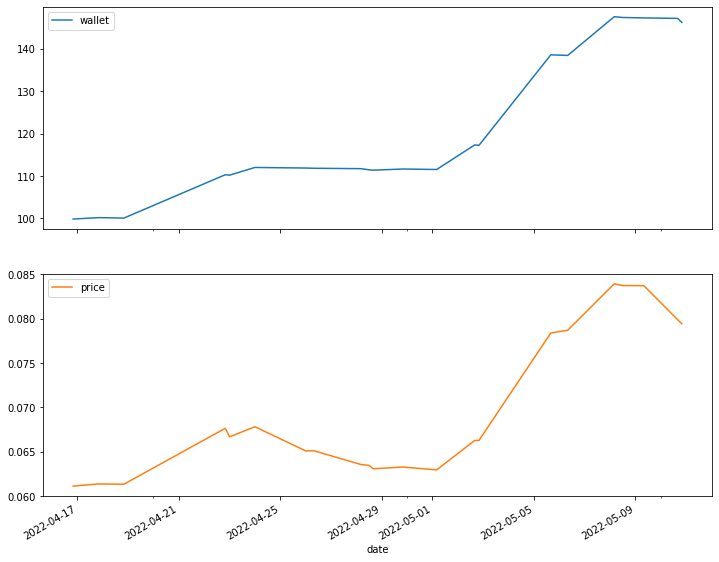

In [10]:
################## ATTENTION avec FTX car vendre si pas de crytos, FTX en achete pour vous. Toujours avoir coin > 0 et surtout achat == 1 pour vendre.

############# Parametres pour le graphique
Montant_initial = usdt
wallet = usdt
initalWallet = wallet
lastAth = 1
lastIndex = dfTest.first_valid_index()
dt = None
dt = pd.DataFrame(columns = ['date','position', 'price', 'frais' ,'fiat', 'coins', 'wallet', 'drawBack'])

############ Ordres
print("debut historique : ",date_decale_julien,"(ce jour a minuit -",decale_jours,"jours)")
print()

## Vente quand EMA3 < EMA11
for index, row in dfTest.iterrows():
  if row['ema11'] > row['ema3'] and achat == 1 and coin > Minimum_order_size :
    achat = 0
    prix_vente = row['c_15M']
    usdt = coin * prix_vente
    frais = usdt * fee
    usdt = truncate(float(usdt - frais), tronque_usdt)
    g = usdt - mise
    gpourcent =  (round(((prix_vente - prix_achat)/prix_achat),4)) * 100
    wallet = usdt
    if wallet > lastAth:
      lastAth = wallet
    print(index,"Vente sur EMA        PRIX:",prix_vente,"     USDT:",usdt,"     gains_pertes:",g,"     %:",gpourcent)
    myrow = {'date': index,'position': "Sell",'price': row['c_15M'],'frais': frais,'fiat': usdt,'coins': coin,'wallet': wallet,'drawBack':(wallet-lastAth)/lastAth}
    dt = dt.append(myrow,ignore_index=True)


## Achat quand EMA3 > EMA11
  if row['ema3'] > row['ema11'] and achat == 0 and usdt > Minimum_price_increment :
    print()
    achat = 1
    prix_achat = row['c_15M']
    coin = usdt / prix_achat
    frais = coin * fee
    coin = truncate(float(coin - frais),tronque_coin)
    usdt = 0
    mise = truncate(float(coin * prix_achat),tronque_usdt)
    wallet = coin * prix_achat
    if wallet > lastAth:
      lastAth = wallet 
    print(index,"Achat sur EMA        PRIX:",prix_achat,"     USDT:",usdt,"             mise:",mise,"   coin:",coin)
    myrow = {'date': index,'position': "Buy",'price': row['c_15M'],'frais': frais * row['c_15M'],'fiat': usdt,'coins': coin,'wallet': wallet,'drawBack':(wallet-lastAth)/lastAth}
    dt = dt.append(myrow,ignore_index=True)

lastIndex = index

print()
 
############# Le graphique
print("")
print("Periode : [" + str(dfTest.index[0]) + "] -> [" +str(dfTest.index[len(dfTest)-1]) + "]")
dt = dt.set_index(dt['date'])
dt.index = pd.to_datetime(dt.index)
dt['resultat'] = dt['wallet'].diff()
dt['resultat%'] = dt['wallet'].pct_change()*100
dt.loc[dt['position']=='Buy','resultat'] = None
dt.loc[dt['position']=='Buy','resultat%'] = None

dt['tradeIs'] = ''
dt.loc[dt['resultat']>0,'tradeIs'] = 'Good'
dt.loc[dt['resultat']<=0,'tradeIs'] = 'Bad'

iniClose = dfTest.iloc[0]['c_15M']
lastClose = dfTest.iloc[len(dfTest)-1]['c_15M']
holdPorcentage = ((lastClose - iniClose)/iniClose) * 100
algoPorcentage = ((wallet - initalWallet)/initalWallet) * 100
vsHoldPorcentage = ((algoPorcentage - holdPorcentage)/holdPorcentage) * 100

print("coin:", coin)
print("usdt:", usdt)
print("Montant initial :",Montant_initial,"$")
print("Montant final   :",round(wallet,2),"$")
print("Gain :",round(wallet,2)-Montant_initial,"€")
print("Gain :",round(algoPorcentage,2),"%")
print("Buy and Hold Performence :",round(holdPorcentage,2),"%")
print("Performance vs Buy and Hold :",round(vsHoldPorcentage,2),"%")
print("Number of negative trades : ",dt.groupby('tradeIs')['date'].nunique()['Bad'])
print("Number of positive trades : ",dt.groupby('tradeIs')['date'].nunique()['Good'])
print("Average Positive Trades : ",round(dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].sum()/dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].count(),2),"%")
print("Average Negative Trades : ",round(dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].sum()/dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].count(),2),"%")
idbest = dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].idxmax()
idworst = dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].idxmin()
print("Best trade +"+str(round(dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].max(),2)),"%, the ",dt['date'][idbest])
print("Worst trade",round(dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].min(),2),"%, the ",dt['date'][idworst])
print("Worst drawBack", str(100*round(dt['drawBack'].min(),2)),"%")
print("Total fee : ",round(dt['frais'].sum(),2),"$")

dt[['wallet','price']].plot(subplots=True, figsize=(12,10))
print('PLOT')


<h1>FIN</h1>